In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import numpy.ma as ma
from matplotlib.patches import Polygon
import cmasher as cmr
from scipy.linalg import null_space
from scipy.linalg import sqrtm
%matplotlib inline


import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
import torch.optim as optim  
import torch.distributions as dist  

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

from thop import profile
from torch.autograd.functional import jacobian

In [7]:
def EI_calculate_pdet(A, Sigma):
    """
    Calculate the Effective Information (EI) based on the pseudo-determinant.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    float: The logarithm of the pseudo-determinant (EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and return the product of singular values greater than 1e-10
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    pseudo_det = np.sum(np.log(s[s > 1e-10]))  # Only consider non-zero singular values
    
    # Effective Information (EI) is the log of the pseudo-determinant scaled by constants
    EI = pseudo_det/2-np.log((2 * np.pi * np.e)**(n / 2))
    
    return EI


def EI_calculate_m_star(A, Sigma, k):
    """
    Calculate the maximum Effective Information (max EI) using the first k singular values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    k (int): The number of singular values to consider.
    
    Returns:
    float: The logarithm of the pseudo-determinant using the top k singular values (max EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and take the product of the first k singular values
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    
    # max EI is the log of the top k singular values' product, scaled by constants
    max_EI = np.sum(np.log(s[:k]))/2-np.log((2 * np.pi * np.e)**(k / 2))
    
    return max_EI

def Gamma(alpha, r_eps, A, Sigma):
    """
    Calculate the Gamma function based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, of size n x n.
    Sigma (ndarray): Input matrix Sigma, of size n x n.
    
    Returns:
    float: The computed Gamma value.
    """
    n = A.shape[1]
    
    # Compute the SVD of A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Compute the SVD of Sigma
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    gamma_value = (2 * np.pi / alpha)**(n / 2) * \
                  np.prod(s_AS2[:r_eps])**(1 / 2 - alpha / 4) * \
                  np.prod(s_S2[:r_eps])**(alpha / 4)
    
    return gamma_value

def gamma_0(alpha, r, A, Sigma):
    """
    Calculate gamma_0 based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma_0 value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma_0 using the top r singular values
    gamma_0_value = np.sum(np.log(s_AS2[:r]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:n]))*(alpha / 4)
    
    return gamma_0_value


def gamma(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return gamma_value

def gamma_geq0(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return max(gamma_value,0)


def calculate_threshold(A, Sigma):
    """
    Calculate the threshold based on the singular values of A^T * Sigma^-1 * A.
    
    Parameters:
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: The threshold value and its corresponding index.
    """
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    
    # Compute the differences between consecutive singular values
    diff = np.diff(s_AS2)
    
    # Compute the ratio of consecutive singular values to avoid division by zero
    ratio = s_AS2[:-1] / s_AS2[1:]  # Element-wise division
    
    # Find the index of the maximum product of difference and ratio
    max_diff_index = np.argmax(np.abs(diff) * np.abs(ratio))
    
    # Return the threshold value and the index (index is adjusted by +1)
    return s_AS2[max_diff_index + 1], max_diff_index + 1

def clear_causal_emergence(A, Sigma):
    """
    Calculate the causal emergence based on changes in effective information (EI) and gamma values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J_R and Delta_Gamma_0 values representing causal emergence.
    """
    n = A.shape[1]
    
    # Calculate the rank of A^T * Sigma^-1 * A
    rk = np.linalg.matrix_rank(A.T @ np.linalg.inv(Sigma) @ A)

    # Calculate the change in effective information (Delta_J_R)
    Delta_J_R = (EI_calculate_m_star(A, Sigma, rk) / rk) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_0)
    Delta_Gamma_0 = (gamma(1, rk, A, Sigma) / rk) - (gamma_0(1, rk, A, Sigma) / n)
    
    return Delta_J_R, Delta_Gamma_0

def vague_causal_emergence(A, Sigma):
    """
    Calculate the vague causal emergence based on the threshold calculation for causal emergence.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing vague causal emergence.
    """
    n = A.shape[1]

    epsilon, rk_eps = calculate_threshold(A, Sigma)  # Get threshold epsilon and rk_eps
    
    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps


def vague_causal_emergence_customize(A, Sigma, rk_eps):
    """
    Calculate the customized vague causal emergence based on a given rk_eps.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    rk_eps (int): The rank parameter for customized calculation.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing customized vague causal emergence.
    """
    n = A.shape[0]

    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps

In [8]:
class Simple_Spring_Model():
    
    def __init__(self, device, R=3):
        self.device = device
        self.R = R
    
    
    def multi_steps_sir(self, s, steps, sigma,lam=1,miu=0.5,rou=-0.5,dt=0.01,interval=1): 
        #One sample point runs multiple time steps.
        batch_size = s.size()[0]
        s_hist = s
        sn_hist = self.perturb(s, 0, rou)
        for t in range(1,steps+1):
            s_next,i_next = self.SIR_step(s[:,0],s[:,1],lam,miu,dt=dt)
            #s_next = torch.Tensor(s_next).unsqueeze(0)
            s_next = torch.cat((s_next.unsqueeze(1),i_next.unsqueeze(1)),1)#s_next.to(self.device)
            if t%interval==0:
                s_hist = torch.cat((s_hist, s_next), 0)
                rand_next = self.perturb(s_next, sigma,rou)
                sn_hist = torch.cat((sn_hist, rand_next), 0)
            s = s_next
        return s_hist[batch_size:,:], sn_hist[batch_size:,:]
    
    def perturb(self, s, sigma,rou):
        prior = distributions.MultivariateNormal(torch.zeros(2,device=self.device), torch.tensor([[1,rou],[rou,1]],device=self.device))
        rand1=prior.sample([s.size()[0]])*sigma
        rand2=prior.sample([s.size()[0]])*sigma
        s1 = s[:,0].unsqueeze(1) + rand1
        s2 = s[:,1].unsqueeze(1) + rand2
        s1_= torch.cat((s1[:,[0]], s2[:,[0]]), 1)
        s2_= torch.cat((s1[:,[1]], s2[:,[1]]), 1)
        sr = torch.cat((s1_, s2_), 1)
        return sr
    
    
    def SIR_step(self,s,i,lam,miu,noise2=0,dt=0.01):
        
        if noise2==0:
            s=s-dt* lam * s * i
            i=i+dt*(lam * s * i - miu * i)
        else:
            prior = distributions.MultivariateNormal(torch.zeros(2,device=self.device).float(), torch.tensor([[1,0],[0,1]],device=self.device).float()*noise2*noise2)
            rand=prior.sample([1])
 
            s=s-dt* lam * s * i+rand[0,0]
            i=i+dt*(lam * s * i - miu * i)+rand[0,1]
        return s,i
    
    def SIS_step(self,s,i,lam,miu,dt=0.01):
        s=s-dt* lam * s * i + dt * miu * i
        i=i+dt* lam * s * i - dt * miu * i
        return s,i

  
    def generate_multistep_sir(self,size_list,steps,lam=1,miu=0.5,sigma=0.03,rou=-0.5,dt=0.01,noise2=0,interval=1):
        #Be able to build a sample set with missing values.
        s=torch.tensor([0],device=self.device)
        i=torch.tensor([0],device=self.device)
        while s.size()[0]<size_list[0]:
            s_=torch.rand([1],device=self.device)
            i_=torch.rand([1],device=self.device) 
            if (s_+i_)<=1:
                s = torch.cat((s,s_),0)
                i = torch.cat((i,i_),0)
        frac=1/(len(size_list)-1)
        for j,size in enumerate(size_list[1:]):
            s1=torch.tensor([frac * j],device=self.device)
            i1=torch.tensor([0],device=self.device)
            while s1.size()[0]<size:
                s_=(torch.rand([1],device=self.device) * frac) + frac * j
                i_=torch.rand([1],device=self.device) 
                if (s_+i_)<=1:
                    s1 = torch.cat((s1,s_),0)
                    i1 = torch.cat((i1,i_),0)
            s = torch.cat((s,s1[1:]),0)
            i = torch.cat((i,i1[1:]),0)
        
        s=s[1:].unsqueeze(1)
        i=i[1:].unsqueeze(1)
        size=s.size()[0]
        idx=torch.randperm(s.nelement())
        s=s.view(-1)[idx].view(s.size())
        i=i.view(-1)[idx].view(i.size())
        history = torch.cat((s,i),1)
        observ_hist = self.perturb(history,sigma,rou)
        for k in range(1,steps+1):
            s,i=self.SIR_step(s,i,lam,miu,noise2=noise2,dt=dt)
            sir = torch.cat((s,i),1)
            sir_p = self.perturb(sir, sigma,rou)
            if k%interval==0:
                history = torch.cat((history, sir),0)
                observ_hist = torch.cat((observ_hist, sir_p),0)
        return observ_hist[:-size,:],observ_hist[size:,:], history[:-size,:],history[size:,:]

def calculate_multistep_predict(model,s,i,steps = 10,stochastic=False,sigma=0.03,rou=-0.5,dt=0.01):
    #Out-of-distribution generalization testing function
    spring = Simple_Spring_Model(device=device)

    if stochastic:
        z = torch.randn([1, 2], device=device)*L/2 
    else:
        z=torch.tensor([[s,i]],device=device) 
    s = spring.perturb(z, sigma,rou)

    s_hist, z_hist = model.multi_step_prediction(s, steps)
    if use_cuda:
        s_hist = s_hist.cpu()
        z_hist = z_hist.cpu()

    rs_hist, rsn_hist = spring.multi_steps_sir(z, steps, sigma,rou=rou,dt=dt) 
    if use_cuda:
        rs_hist = rs_hist.cpu()
        rsn_hist = rsn_hist.cpu()

    means=torch.mean(torch.abs(rsn_hist-s_hist[1:,:]))
    #cums=torch.cumsum(means, 0)[-1] / steps
    return means.item()

In [9]:
# 定义神经网络  
class MultivariateGaussianModel(nn.Module):  
    def __init__(self, input_size, hidden_size, output_size,device):  
        super(MultivariateGaussianModel, self).__init__()  
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc_mu = nn.Linear(hidden_size, output_size)  # 输出均值  
        self.fc_L = nn.Linear(hidden_size, output_size * (output_size + 1) // 2)  # 输出 Cholesky 分解的下三角部分  
        self.relu = nn.ReLU()  
        self.output_size = output_size  
        self.device = device

    def forward(self, x):  
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        mu = self.fc_mu(x)  # 均值  
        L_elements = self.fc_L(x)  # Cholesky 分解的下三角部分  

        # 构建下三角矩阵 L  
        L = torch.zeros(x.size(0), self.output_size, self.output_size, device=device)  
        indices = torch.tril_indices(row=self.output_size, col=self.output_size, offset=0)  
        L[:, indices[0], indices[1]] = L_elements  
        L.diagonal(dim1=1, dim2=2).exp_()  # 对角线元素取指数确保正定性  

        return mu, L  

In [ ]:
# 参数设置  
input_size = 10  # 输入维度  
hidden_size = 128  
output_size = 2  # 输出维度（多元高斯分布的维度）  
learning_rate = 0.001  
num_epochs = 100  
batch_size = 32  

# 生成随机数据  
X = torch.randn(1000, input_size,device=device)  # 1000 个样本  
Y = torch.randn(1000, output_size,device=device)  # 对应的输出  

# 初始化模型、损失函数和优化器  
model = MultivariateGaussianModel(input_size, hidden_size, output_size,device=device)  
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

# 自定义多元高斯分布的负对数似然损失函数  
def nll_loss(mu, L, y):  
    # 计算协方差矩阵 Sigma = L L^T  
    Sigma = torch.matmul(L, L.transpose(1, 2))  
    # 计算多元高斯分布的负对数似然  
    mvn = dist.MultivariateNormal(loc=mu, scale_tril=L)  
    return -mvn.log_prob(y)  

# 训练模型  
for epoch in range(num_epochs):  
    for i in range(0, len(X), batch_size):  
        inputs = X[i:i+batch_size]  
        labels = Y[i:i+batch_size]  

        # 前向传播  
        mu, L = model(inputs)  
        loss = nll_loss(mu, L, labels).mean()  

        # 反向传播和优化  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')  

In [ ]:
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
spring = Simple_Spring_Model(device=device)
test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)

train_data=train_data
test_data=test_data
ss,sps,ls,lps = train_data

# 参数设置  
input_size = ss.shape[1]    # 输入维度  
hidden_size = 128  
output_size = sps.shape[1]  # 输出维度（多元高斯分布的维度）  
learning_rate = 0.001  
num_epochs = 500  
batch_size = 100

# 生成随机数据  
X = ss  # 1000 个样本  
Y = sps  # 对应的输出  

# 初始化模型、损失函数和优化器  
model = MultivariateGaussianModel(input_size, hidden_size, output_size,device=device)  
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

# 自定义多元高斯分布的负对数似然损失函数  
def nll_loss(mu, L, y):  
    # 计算协方差矩阵 Sigma = L L^T  
    Sigma = torch.matmul(L, L.transpose(1, 2))  
    # 计算多元高斯分布的负对数似然  
    mvn = dist.MultivariateNormal(loc=mu, scale_tril=L)  
    return -mvn.log_prob(y)  

# 训练模型  
for epoch in range(num_epochs):  
    for i in range(0, len(X), batch_size):  
        inputs = X[i:i+batch_size]  
        labels = Y[i:i+batch_size]  

        # 前向传播  
        mu, L = model(inputs)  
        loss = nll_loss(mu, L, labels).mean()  

        # 反向传播和优化  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')  

# 保存模型  
#torch.save(model.state_dict(), 'multivariate_gaussian_model.pth')

Epoch [1/500], Loss: -7.4688
Epoch [2/500], Loss: -7.5424
Epoch [3/500], Loss: -7.5719
Epoch [4/500], Loss: -7.6684
Epoch [5/500], Loss: -7.7004
Epoch [6/500], Loss: -7.7160
Epoch [7/500], Loss: -7.7346
Epoch [8/500], Loss: -7.7457
Epoch [9/500], Loss: -7.7505
Epoch [10/500], Loss: -7.7457
Epoch [11/500], Loss: -7.7442
Epoch [12/500], Loss: -7.7593
Epoch [13/500], Loss: -7.7744
Epoch [14/500], Loss: -7.7968
Epoch [15/500], Loss: -7.8026
Epoch [16/500], Loss: -7.8043
Epoch [17/500], Loss: -7.7966
Epoch [18/500], Loss: -7.7906
Epoch [19/500], Loss: -7.7939
Epoch [20/500], Loss: -7.7884
Epoch [21/500], Loss: -7.7873
Epoch [22/500], Loss: -7.7956
Epoch [23/500], Loss: -7.8054
Epoch [24/500], Loss: -7.8166
Epoch [25/500], Loss: -7.8413
Epoch [26/500], Loss: -7.8483
Epoch [27/500], Loss: -7.8546
Epoch [28/500], Loss: -7.8619
Epoch [29/500], Loss: -7.8652
Epoch [30/500], Loss: -7.8674
Epoch [31/500], Loss: -7.8684
Epoch [32/500], Loss: -7.8664
Epoch [33/500], Loss: -7.8759
Epoch [34/500], Los

In [ ]:
torch.save(model.state_dict(), 'multivariate_gaussian_model.pth')

In [ ]:
s,sp,l,lp=test_data
xx = s
scale = 4
func = lambda x:model.fc_mu(model.relu(model.fc2(model.relu(model.fc1(x.unsqueeze(0))))))

S_s = torch.zeros([xx.size()[0],scale])
ASA_s = torch.zeros([xx.size()[0],scale,scale])
A_s = torch.zeros([xx.size()[0],scale,scale])
Sigma_s = torch.zeros([xx.size()[0],scale,scale])

max_diff_index_s = []

for i in range(xx.size()[0]):
    Ax,L=model(xx[i,:])
    Sigma_x = torch.matmul(L, L.transpose(1, 2)) 
    (Kappa, Q) = torch.linalg.eig(Sigma_x) 
    Sigma_std = Q@torch.diag((Kappa**(1/2))[0])@torch.linalg.inv(Q)
    sigmas_matrix = Sigma_std.real[0]

    jac=jacobian(func, xx[i,:]) #use pytorch's jacobian function to obtain jacobian matrix
    A_s[i] = jac
    Sigma_s[i] = sigmas_matrix
    ASA = jac[0].T@torch.linalg.inv(sigmas_matrix)@jac[0]
    ASA_s[i] = ASA
    _,S,_ = torch.linalg.svd(ASA)
    S_s[i] = S

    rk_eps = 2

A = A_s.mean(0).detach().cpu()
Sigma = Sigma_s.mean(0).detach().cpu()
ASA = ASA_s.mean(0)

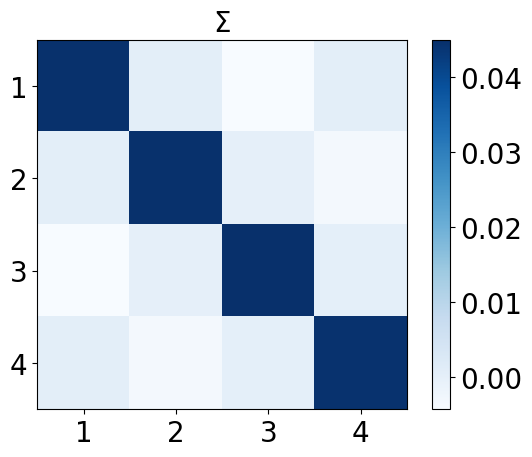

In [ ]:
plt.imshow(Sigma,cmap = "Blues")
plt.title('$\Sigma$',fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
#plt.savefig('./Figure/SIR_Matrix.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

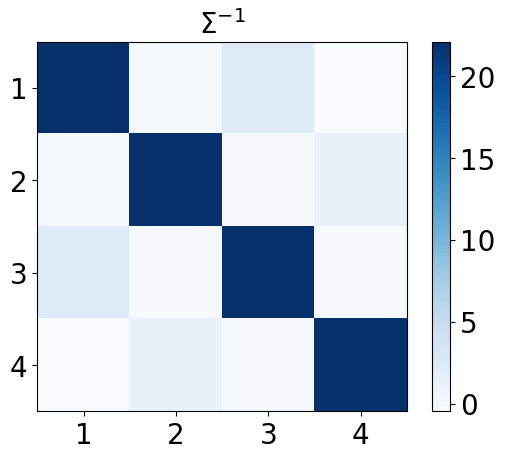

In [ ]:
plt.imshow(torch.linalg.inv(sigmas_matrix).cpu().detach().numpy(),cmap = "Blues")
plt.title('$\Sigma^{-1}$',fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.savefig('./Figure/SIR_Matrix_sigma.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

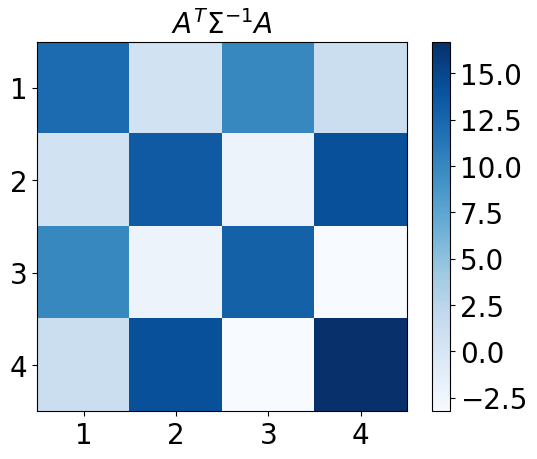

In [ ]:
plt.imshow(ASA.cpu().detach().numpy(),cmap = "Blues")
plt.title('$A^T\Sigma^{-1}A$',fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.savefig('./Figure/SIR_Matrix_A.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

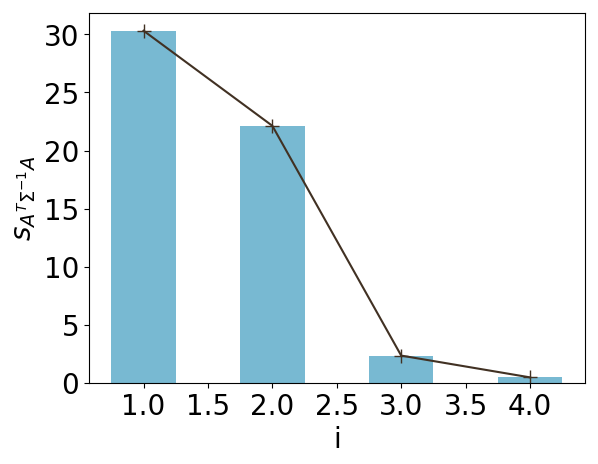

In [ ]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']
P,S,Q = torch.linalg.svd(ASA)
P,S1,Q = torch.linalg.svd(torch.linalg.inv(sigmas_matrix))

sequence = S.cpu().detach().numpy()
sequence_2 = S.cpu().detach().numpy()

plt.bar([1,2,3,4],sequence,color = colors[4],width=0.5)
plt.xlabel('i',fontsize=20)
plt.ylabel('$s_{A^T\Sigma^{-1}A}$',fontsize=20)
plt.plot([1,2,3,4],sequence,color = colors[5],marker ='+',markersize =10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.hlines(2,0.5,8.5,linestyles='--')
#plt.savefig('./Figure/SIR_SVD_clear.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

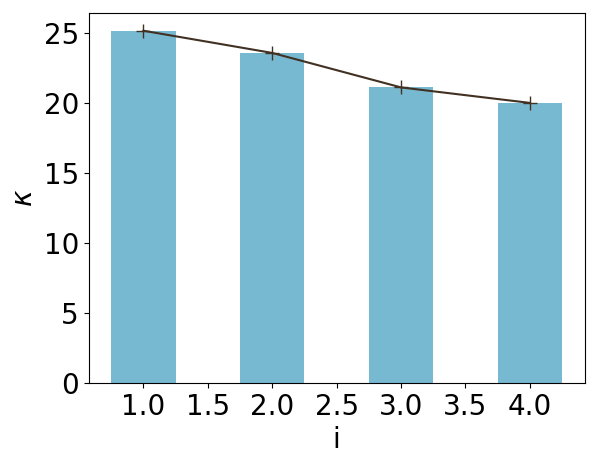

In [ ]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']
P,S,Q = torch.linalg.svd(torch.linalg.inv(sigmas_matrix))

sequence = S.cpu().detach().numpy()

plt.bar([1,2,3,4],sequence,color = colors[4],width=0.5)
plt.xlabel('i',fontsize=20)
plt.ylabel('$\kappa$',fontsize=20)
plt.plot([1,2,3,4],sequence,color = colors[5],marker ='+',markersize =10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.hlines(2,0.5,8.5,linestyles='--')
#plt.savefig('./Figure/SIR_SVD_clear.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()